In [ ]:
import numpy as np
import pandas as pd


In [ ]:
np.random.seed(23)

> random.multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)
Draw random samples from a multivariate normal distribution.

The multivariate normal, multinormal or Gaussian distribution is a generalization of the one-dimensional normal distribution to higher dimensions. Such a distribution is specified by its mean and covariance matrix. These parameters are analogous to the mean (average or “center”) and variance (standard deviation, or “width,” squared) of the one-dimensional normal distribution.



Parameters:

mean :
1-D array_like, of length N
Mean of the N-dimensional distribution.

cov :
2-D array_like, of shape (N, N)
Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.

Standard normal distribution has  
1) mean = 0
2) variance = 1
3) standard deviation = 1


*Standard deviation is the square root of variance*

Multivariate normal distribution has

1. Mean vector = 0 (centered at origin)
2. Covariance matrix = Identity matrix  (i.e unit spread in every direction)

In [ ]:
mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
# 20 samples of class 1
class1_sample = np.random.multivariate_normal(
    mu_vec1, cov_mat1, 20
)
class1_sample

df = pd.DataFrame(class1_sample,columns=[
    'feature1','feature2','feature3'
])
df['target'] = 1

In [ ]:
# 20 samples of class 2
# differentiate the data cloud by making mean at 1,1,1
mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(
    class2_sample, columns=[
        'feature1','feature2','feature3'
    ]
    )
df1['target'] = 0



In [ ]:
df = pd.concat([df,df1],ignore_index=True)
df = df.sample(40)

In [ ]:
df.head()

,feature1,feature2,feature3,target
2,-0.367548,-1.137460,-1.322148,1
34,0.177061,-0.598109,1.226512,0
14,0.420623,0.411620,-0.071324,1
11,1.968435,-0.547788,-0.679418,1
12,-2.506230,0.146960,0.606195,1


*for dynamic interactive visualisation use plotly*

In [ ]:
import plotly.express as px


In [ ]:
fig = px.scatter_3d(
    df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
    color = df['target'].astype('str')
)

type(fig)

plotly.graph_objs._figure.Figure

In [ ]:
fig.update_traces(
    marker=dict(size=12,
                line=dict(width=2, color='DarkSlateGrey')),
    selector = dict(mode = 'markers')

)
fig.show()

# STEP 1 : MEAN CENTERING VIA STANDARD SCALING

after scaling -> mean becomes 0, standard deviation becomes 1 -> mean centering + unit variance

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:-1] = scaler.fit_transform(df.iloc[:,0:-1])

# STEP 2 : FIND COVARIANCE MATRIX

In [ ]:
covariance_matrix = np.cov(
    # pass the 3 features
    [df.iloc[:,0], df.iloc[:,1], df.iloc[:,2]]
)
print("Covariance Matrix:\n", covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


variance of each feature at diagonals, covariance between features at non-diagonals

-ve cov value means : x is indirectly proportional to y

+ve cov value means : x is directly proportional to y

# STEP 3 : FINDING EIGEN VALUES AND EIGEN VECTORS for covariance matrix

In [ ]:
np.linalg.eig(covariance_matrix)

EigResult(eigenvalues=array([1.3536065 , 0.94557084, 0.77774573]), eigenvectors=array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]]))

eigen vectors ->
1. on transformation, no change in direction
2. magnitude can change even in reverse, and can shrink or stretch

eigen vectors are called the principle components

the vector with the highest eigen value will be at the top, showing that its the most important and has the highest spread of data (high variance) -> best representation

in 3d -> we will have 3 eigen vectors , equal to the no of features i.e 3

in nd -> we are gonna have n principal components , i.e equal to the number of columns which is n

eigen value is the stretching or shrinking factor, the largest eigen vector will have the largest eigen value

for ex : (-1,1) -> on transformation -> (-1.5,1.5)
eigen value = 1.5

(1,0) -> (3,0) eigen value = 3

*linear transformation(matrix A) when applied on vector(v) = multiplying the same vector(v) with a scalar lambda (eigen value)*

the first eigen vector explains the highest variance in the original data and the value reduces from here, and make sure that 90% of variance is explained by the top n eigen vectors for dimensionality reduction (PCA) that will determine the number of principle components required.

choose the unit vector(principle component) in which variance is maximum

spread is directly proportional to variance

*the largest eigenvector of the covariance matrix always points into the directionof the largest variance of the data*

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [ ]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [ ]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

# STEP 4 : PROJECT ALL POINTS FROM HIGH DIM SPACE ONTO PRINCIPLE COMPONENTS

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
  def __init__(self,xs,ys,zs,*args,**kwargs):
    # initialising all the attributes of FancyArrowPatch class
    # into Arrow3D object
    # FancyArrowPatch draws 2d arrows, so initially we pass
    # dummy start and end points.
    FancyArrowPatch.__init__(self,(0,0),(0,0),*args,**kwargs)
    # next set the Arrow3D attributes
    self._verts3d = xs,ys,zs

  def draw(self, renderer):
    # store the 3d coordinates
    xs3d, ys3d, zs3d = self._verts3d
    # project from 3d to 2d
    xs, ys, zs = proj3d.proj_transform(
        xs3d,ys3d,zs3d, self.axes.M # Corrected from renderer.M to self.axes.M
    )
    # set the start and end point of the arrow
    self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
    # now draw the 2d arrow
    FancyArrowPatch.draw(self,renderer)

  def do_3d_projection(self):
    # This method is required for proper 3D rendering order.
    # It returns the average z-coordinate, used for sorting artists.
    xs3d, ys3d, zs3d = self._verts3d
    return (zs3d[0] + zs3d[1]) / 2

**In PCA, eigenvectors originate from the mean.**

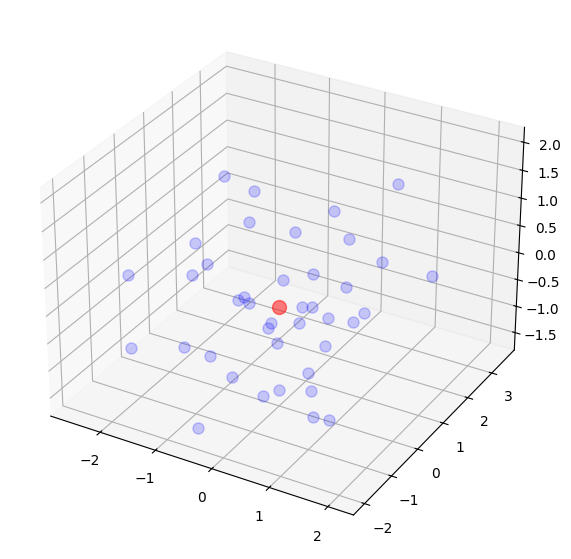

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(
    df['feature1'],df['feature2'],df['feature3'], 'o', markersize=8, color='blue', alpha=0.2)
ax.plot(
    [df['feature1'].mean()],
    [df['feature2'].mean()],
    [df['feature3'].mean()], 'o', markersize=10, color='red', alpha=0.5
)


In [ ]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

In [ ]:
eigen_vectors.T

array([[-0.53875915, -0.65608325, -0.52848211],
       [-0.69363291, -0.01057596,  0.72025103],
       [ 0.47813384, -0.75461442,  0.44938304]])

Each v is one full eigenvector.

v[0] → 0.7   (component along feature1 / x-axis)

v[1] → -0.2  (component along feature2 / y-axis)

v[2] → 0.68  (component along feature3 / z-axis)

So v[0] is simply:

The weight of feature1 in that principal direction.

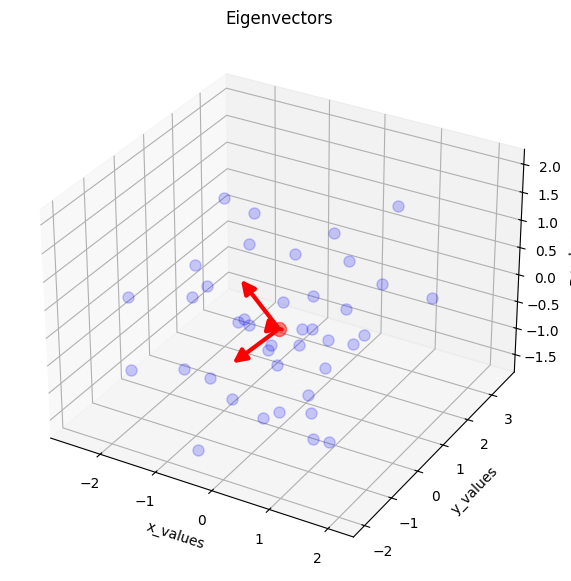

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(
    df['feature1'],df['feature2'],df['feature3'], 'o', markersize=8, color='blue', alpha=0.2)
ax.plot(
    [df['feature1'].mean()],
    [df['feature2'].mean()],
    [df['feature3'].mean()], 'o', markersize=10, color='red', alpha=0.5
)

for v in eigen_vectors.T:
  a = Arrow3D(
      # start , end (mean + dirn of eigen vector 1(feature wise))
      [df['feature1'].mean(), v[0]],
      [df['feature2'].mean(), v[1]],
      [df['feature3'].mean(), v[2]],
      mutation_scale=20, lw=3, arrowstyle="-|>", color="r"

  )
  # add artist for drawing arrow in 3D
  ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')
plt.show()

**Eigen vectors : New orthogonal directions that describe maximum variance in the data**

**Each eigenvector is a combination of all features.**

After covariance matrix decomposition we get eigen values and eigen vectors ->

1. Each eigen vector is stored in a column

In Matplotlib, everything drawn on a figure is an Artist.

An Axes object is basically:

A container that holds drawable objects (artists)

**in PCA -> arrow start at the mean and end at the eigenvector**

1. Start = center of data

2. End = one step in that principal direction

In [ ]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

In [ ]:
eigen_vectors[:,0]

array([-0.53875915, -0.65608325, -0.52848211])

In [ ]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

**The normalized (unit “length”) eigenvectors, such that the column eigenvectors[:,i] is the eigenvector corresponding to the eigenvalue eigenvalues[i]**

Columns = eigenvectors

Rows = components of each eigenvector

In [ ]:
pc = eigen_vectors.T[0:2]
pc

array([[-0.53875915, -0.65608325, -0.52848211],
       [-0.69363291, -0.01057596,  0.72025103]])

In [ ]:
pc.shape

(2, 3)

*project the data on to the prinicpal components*

*2 directions : 1st direction -> PC1 -> dirn of max variance*

*PC2 -> dirn of second maximum variance*

In [105]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)
# 40,3 :  3,2 ->40,2
new_df = pd.DataFrame(
    transformed_df,columns=['PC1','PC2']
)
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,2.302877,-0.757593,1
1,0.524464,0.520221,0
2,0.380275,-0.459443,1
3,0.534262,-1.773773,1
4,1.610434,1.747819,1


In [106]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     40 non-null     float64
 1   PC2     40 non-null     float64
 2   target  40 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 1.1 KB


In [108]:
new_df['target'] = new_df['target'].astype('str')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     40 non-null     float64
 1   PC2     40 non-null     float64
 2   target  40 non-null     object 
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [112]:
fig = px.scatter(
    x = new_df['PC1'],
    y = new_df['PC2'],
    color = new_df['target'],
    color_discrete_sequence=px.colors.qualitative.G10
)
fig.update_traces(
    marker = dict(
        size = 12,
        line = dict(
            width = 2,
            color = 'DarkSlateGrey'

    )),
    selector = dict(
        mode = 'markers'
    )
)
fig.show()